In [54]:
import tweepy
from textblob import TextBlob
import pandas as pd
import sys
import csv
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import spacy
import pandas as pd 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re
import os
from collections import Counter
import logging
import time
import pickle
import itertools
from PIL import Image
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from textblob import Word
from nltk.corpus import stopwords
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/VasundharaJain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/VasundharaJain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### This project aims to create a model that predicts the sentiment of Tottenham Hotspur fans on the appointment of Nuno Espirito Santos as the new manager of the club. This model would then be used to do a sentiment analysis of a Tottenham hostpur fan page.

#### The initial data to create the model will be base on the replies of the following Tweet: https://twitter.com/SpursOfficial/status/1410317279598944263

# Data Collection using Twitter API

In [67]:
secrets = pd.read_csv("secrets.csv")

api_key=secrets["api_key"][0]
api_secret = secrets["api_secret"][0]
access_key = secrets["access_key"][0]
access_secret = secrets["access_secret"][0]

auth = tweepy.OAuthHandler(api_key,api_secret)
auth.set_access_token(access_key,access_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

# Importing secrets and initiating a connection with Twitter API

In [131]:
name = 'spursofficial'
tweet_id = '1410317279598944263'
replies=[]
for tweet in tweepy.Cursor(api.search,q='to:'+name, result_type='recent').items():
    if hasattr(tweet, 'in_reply_to_status_id_str'):
        if (tweet.in_reply_to_status_id_str==tweet_id):
            replies.append(tweet)
            
reply_list = []
for reply in replies:
    reply_list.append((reply.user.screen_name, reply.text, reply.source, reply.user.name, reply.user.followers_count, reply.user.location, reply.lang))
    
# Storing all replies to the Tottenham announcement of Nuno appointment

In [424]:
len(reply_list)

1447

In [425]:
df = pd.DataFrame(reply_list,columns =["UserID","Tweet","Source","Name","Followers","Location","Language"])

In [164]:
df.head()

,UserID,Tweet,Source,Name,Followers,Location,Language
0,Raihan22458141,@SpursOfficial He looks like my barber u bottl...,Twitter for iPhone,Raihan,5,NaN,en
1,UmerulFarook4,@SpursOfficial https://t.co/IixqmNh8VP,Twitter for Android,Umerul Farook,0,NaN,und
2,ham61403822,@SpursOfficial Les goo,Twitter for iPhone,ndomballer.,0,NaN,en
3,Patson73677209,@SpursOfficial welcome Nuno,Twitter for Android,Patson,1,NaN,tl
4,Essexren,@SpursOfficial Good luck hope is helps towards...,Twitter for Android,Renee,28,NaN,en


# Data cleaning

In [165]:
df['Tweet'] = df['Tweet'].str[15:]
# Removing '@SpursOfficial' from the beginning of every Tweet

In [166]:
df =df.drop(["UserID", "Name"], axis=1) # Dropping UserID and Name columns

In [167]:
df.Location.isna().sum()

583

In [168]:
df =df.drop(["Location"], axis=1) #Dropping Location column as a huge proportion of the observations lack a location

In [169]:
df.Source.value_counts()

Twitter for iPhone     704
Twitter for Android    576
Twitter Web App        140
Twitter for iPad        22
TweetDeck                4
Twitter for Mac          1
Name: Source, dtype: int64

In [ ]:
def source(text):
    if "iPhone" in text:
        return "iPhone"
    if "Android" in text:
        return "Android"
    if "Web App" in text:
        return "Web App"
    if "TweetDeck" in text:
        return "TweetDeck"
    if "Mac" in text:
        return "Mac"
    
df["Source"] = df["Source"].apply(source)

# Shortening the Source column for ease

In [ ]:
def check_img(tweet):
    tweetlist = tweet.split()
    
    for component in tweetlist:
        if "https://" in component:
            tweetlist.remove(component)
    return " ".join(tweetlist)
    
    
df["Tweet"] = df["Tweet"].apply(check_img)
df = df[df.Tweet != ""]
df =df.reset_index().drop("index", axis=1) 

# Removing any pictures from the Tweets and retaining only the text. Removing all Tweets that have no text but only picture(s)



In [164]:
df

,Tweet,Source,Followers,Sentiment,label,processed_tweet
0,look like barber bottlejobs shit,iPhone,5,Not positive,0,look like barber bottlejobs shit
1,le goo,iPhone,0,Positive,1,le goo
2,good luck hope help towards good season ahead,Android,28,Positive,1,good luck hope help towards good season ahead
3,business expected,Android,3,Not positive,0,business expected
4,tottenham fan really like nuno separate like m...,Web App,5,Positive,1,tottenham fan really like nuno separate like m...
...,...,...,...,...,...,...
962,man get sancho arsenal getting good player cit...,iPhone,904,Not positive,0,man get sancho arsenal getting good player cit...
963,nuno dream,iPhone,90,Positive,1,nuno dream
964,finished,iPhone,31,Not positive,0,finished
965,trash,Web App,0,Not positive,0,trash


In [172]:
import re

emoji_pat = '[\U0001F300-\U0001F64F\U0001F680-\U0001F6FF\u2600-\u26FF\u2700-\u27BF]'
shrink_whitespace_reg = re.compile(r'\s{2,}')

def clean_text(raw_text):
    reg = re.compile(r'({})|[^a-zA-Z\'’`]'.format(emoji_pat)) # line a
    result = reg.sub(lambda x: ' {} '.format(x.group(1)) if x.group(1) else ' ', raw_text)
    return shrink_whitespace_reg.sub(' ', result)

df["Tweet"]=df["Tweet"].apply(clean_text)
df = df[df.Tweet.str.strip() != ""]
df =df.reset_index().drop("index", axis=1)



# Removing everything but alphabets and emojis. Removing tweets with only numbers and/or special characters (excluding emojis) 

In [173]:
df = df[df["Language"] == "en"]
df = df.drop("Language", axis=1) #Removing non english Tweets

In [174]:
df.head()

,Tweet,Source,Followers
0,He looks like my barber u bottlejobs shit club,iPhone,5
1,Les goo,iPhone,0
3,Good luck hope is helps towards a good season ...,Android,28
4,Business club as expected,Android,3
5,Not a Tottenham fan but I really like Nuno 😲 h...,Web App,5


In [175]:
df.to_csv("clean_data.csv") # Downloading the dataset for labelling

In [183]:
df = pd.read_csv("clean_data_2.csv") # Importing Labelled dataset
df = df.drop(["Unnamed: 0", "Temp"], axis=1)
df.head()

,Tweet,Source,Followers,Sentiment
0,He looks like my barber u bottlejobs shit club,iPhone,5,Not positive
1,Les goo,iPhone,0,Positive
2,Good luck hope is helps towards a good season ...,Android,28,Positive
3,Business club as expected,Android,3,Not positive
4,Not a Tottenham fan but I really like Nuno 😲 h...,Web App,5,Positive


In [184]:
def lower_case(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    print(df['Tweet'].head())
    
lower_case(df) #Converting everything to lowercase



0       he looks like my barber u bottlejobs shit club
1                                              les goo
2    good luck hope is helps towards a good season ...
3                            business club as expected
4    not a tottenham fan but i really like nuno 😲 h...
Name: Tweet, dtype: object


In [185]:
stop = stopwords.words('english')
def stop_words_removal(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    print(df['Tweet'].head())
    
stop_words_removal(df) #Removing Stop Words

0             looks like barber u bottlejobs shit club
1                                              les goo
2       good luck hope helps towards good season ahead
3                               business club expected
4    tottenham fan really like nuno 😲 separate mana...
Name: Tweet, dtype: object


In [186]:
def remove_single_character_words(text):
    split_list = text.split()
    output_list = []
    for i in range(len(split_list)):
        if len(split_list[i]) > 1:
            output_list.append(split_list[i])
            
    return " ".join(output_list)

df["Tweet"]=df["Tweet"].apply(remove_single_character_words) #Removing single character words

df.head()

,Tweet,Source,Followers,Sentiment
0,looks like barber bottlejobs shit club,iPhone,5,Not positive
1,les goo,iPhone,0,Positive
2,good luck hope helps towards good season ahead,Android,28,Positive
3,business club expected,Android,3,Not positive
4,tottenham fan really like nuno separate manage...,Web App,5,Positive


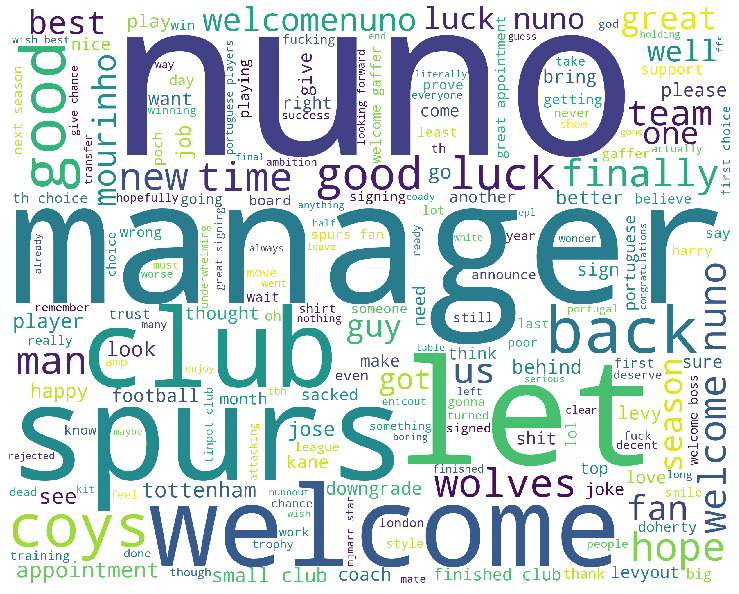

In [7]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
wordcloud_draw(df.Tweet,'white')

# Creating a Wordcloud to see the most frequently used words


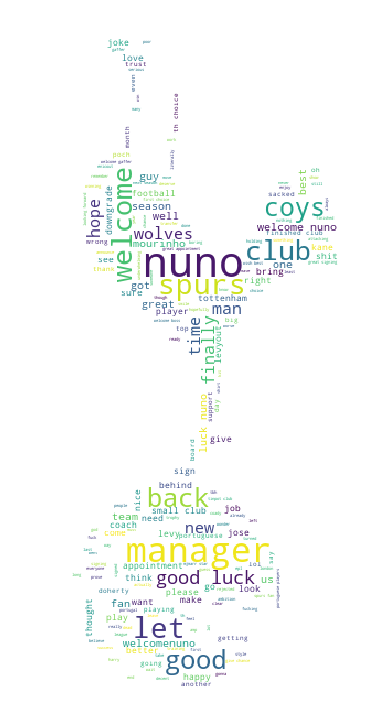

In [8]:
logo_mask = np.array(Image.open("logo.jpg"))



def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color, mask = logo_mask,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
wordcloud_draw(df.Tweet,'white')

# Forming a wordcloud in the shape of the Tottenham Logo

### While there are positive words like 'Welcome' and 'Good', there are some negative ones like 'underwhelming' and 'downgrade'.

In [187]:
freq = pd.Series(' '.join(df['Tweet']).split()).value_counts()[:10]
freq

nuno       144
welcome    102
good        91
club        88
manager     78
spurs       68
luck        53
back        50
get         48
coys        43
dtype: int64

In [188]:
freq =  ["Spurs","club","manager","Nuno"]
def frequent_words_removal(df):    
    df['Tweet'] = df['Tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    print(df['Tweet'].head())
    
frequent_words_removal(df)

# Removing the most frequently used words that wouldn't help in comparing positive and non-positive tweets

0                    looks like barber bottlejobs shit
1                                              les goo
2       good luck hope helps towards good season ahead
3                                    business expected
4    tottenham fan really like nuno separate like m...
Name: Tweet, dtype: object


In [189]:
def lemmatization(df):
    df['Tweet'] = df['Tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    print(df['Tweet'].head())
    
lemmatization(df)
# Shortening words to their lemmas

0                     look like barber bottlejobs shit
1                                               le goo
2        good luck hope help towards good season ahead
3                                    business expected
4    tottenham fan really like nuno separate like m...
Name: Tweet, dtype: object


Text(0.5, 1.0, 'Dataset labels distribuition')

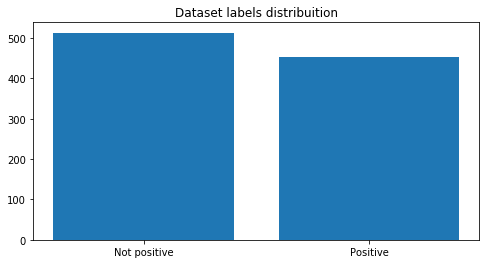

In [13]:
target_cnt = Counter(df.Sentiment)

plt.figure(figsize=(8,4))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

#### The distribution of Positive and Non-positive tweets looks almost equal. No balancing is required.

In [14]:
pd.pivot_table(df, index = ["Sentiment", "Source"], values="Tweet",  aggfunc = "count")

Tweet
Sentiment    Source          
Not positive Android      204
             TweetDeck      1
             Web App       51
             iPhone       249
Positive     Android      178
             TweetDeck      2
             Web App       44
             iPhone       221

#### The distribution of both positive and non-positive are identical across the different platforms

In [15]:
pd.pivot_table(df, index = ["Sentiment"], values="Followers",  aggfunc = ["mean","median"])

,mean,median
,Followers,Followers
Sentiment,,
Not positive,1062.836257,189.0
Positive,637.165198,151.5


#### The median Followers of people in either categories aren't very different. However, the mean is very high. Perhaps, some users with high following (Influencers) have replied  non-positively

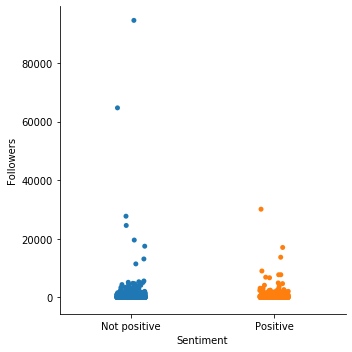

In [16]:
sns.catplot(x="Sentiment", y="Followers", data=df)

In [17]:
df[df["Followers"] > 45000]

,Tweet,Source,Followers,Sentiment
387,daniel levy spoken reverting back dna playing ...,iPhone,64657,Not positive
430,feel like christmas day get sock job warm snug...,Android,94498,Not positive


#### These influencers with a high follower count are clearly unhappy with the appointment of the new Tottenham manager

In [18]:
df["label"] = np.where(df["Sentiment"] == "Positive",1,0) # Creating Binary variable for the label

In [190]:
tokenized_tweet = df.Tweet.apply(lambda x: x.split())
tokenized_tweet #Tokenizing each Tweet

0                 [look, like, barber, bottlejobs, shit]
1                                              [le, goo]
2      [good, luck, hope, help, towards, good, season...
3                                   [business, expected]
4      [tottenham, fan, really, like, nuno, separate,...
                             ...                        
962    [man, get, sancho, arsenal, getting, good, pla...
963                                        [nuno, dream]
964                                           [finished]
965                                              [trash]
966                                    [tottenham, news]
Name: Tweet, Length: 967, dtype: object

stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet #Stemming the tweets

In [20]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])
    
df["processed_tweet"] = tokenized_tweet

# Modelling

In [21]:
bow_vectorizer = CountVectorizer()
bow = bow_vectorizer.fit_transform(df.Tweet)
count_feat = pd.DataFrame(bow.toarray())
count_feat.head() # Using Count Vectorizer

,0,1,2,3,4,5,6,7,8,9,...,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [191]:
tfidf_vectorizer= TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(df.Tweet)
tfidf_feat = pd.DataFrame(tfidf.toarray())
tfidf_feat.head() #  Usin TF-IDF

,0,1,2,3,4,5,6,7,8,9,...,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
model = []
model.append(("LR",LogisticRegression(random_state = 42)))
model.append(("RF", RandomForestClassifier(random_state = 42)))
model.append(("GB",GradientBoostingClassifier(random_state = 42)))
model.append(("DT", DecisionTreeClassifier(random_state = 42)))
model.append(("NB", GaussianNB()))
model.append(("KNN",KNeighborsClassifier()))
model.append(("SVC", SVC(random_state = 42)))

In [24]:
for mod,clf in model:
    scores = cross_val_score(clf,count_feat, df["Sentiment"],scoring = "accuracy", cv=5)
    print("Model is %s and Score %f"%(mod, scores.mean()))

Model is LR and Score 0.803590
Model is RF and Score 0.667074
Model is GB and Score 0.772550
Model is DT and Score 0.653646
Model is NB and Score 0.650478
Model is KNN and Score 0.602927
Model is SVC and Score 0.775648


In [25]:
for mod,clf in model:
    scores = cross_val_score(clf,tfidf_feat, df["Sentiment"],scoring = "accuracy", cv=5)
    print("Model is %s and Score %f"%(mod, scores.mean()))

Model is LR and Score 0.791128
Model is RF and Score 0.676385
Model is GB and Score 0.765312
Model is DT and Score 0.663998
Model is NB and Score 0.639106
Model is KNN and Score 0.576059
Model is SVC and Score 0.795294


#### SVC and Logistic Regression are the best performing models

In [195]:
param_grid = {'C': [ 0.001,0.01,0.1,1,10,100]}
grid = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5)
grid.fit(count_feat,df["Sentiment"])
grid.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [196]:
model1 = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
score =  cross_val_score(model1,count_feat, df["Sentiment"], scoring = "accuracy", cv=5)
score.mean()

0.8035895518401794

In [198]:
grid = GridSearchCV(LogisticRegression(random_state=42, max_iter = 5000), param_grid, cv=5)
grid.fit(tfidf_feat,df["Sentiment"])
grid.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [199]:
model2 = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
score =  cross_val_score(model2,tfidf_feat, df["Sentiment"], scoring = "accuracy", cv=5)

score.mean()

0.8211313498210565

In [202]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid_svc = GridSearchCV(SVC(random_state=42), param_grid=param_grid, cv=5)
grid_svc.fit(count_feat, df["Sentiment"])
grid_svc.best_estimator_


SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [203]:
model3 = SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

score =  cross_val_score(svc,count_feat, df["Sentiment"], scoring = "accuracy", cv=5)

score.mean()

0.7756476683937825

In [204]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid_svc = GridSearchCV(SVC(random_state=42), param_grid=param_grid, cv=5)
grid_svc.fit(tfidf_feat, df["Sentiment"])
grid_svc.best_estimator_



SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [398]:
model4 = SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

score =  cross_val_score(svc,tfidf_feat, df["Sentiment"], scoring = "accuracy", cv=5)

score.mean()

0.7932054911596603

In [26]:
best_model = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

best_model = model1 = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_feat, df["label"],test_size = 0.2, random_state = 42)

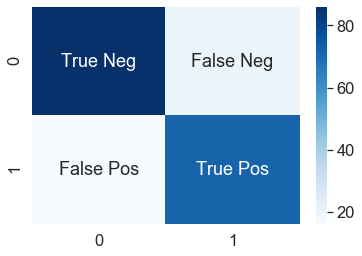

In [49]:
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)
sns.set(font_scale=1.5)
cm = confusion_matrix(predictions, y_test)
labels = ['True Neg','False Neg','False Pos','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.show()

In [50]:
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.814433
Precision: 0.818182
Recall: 0.782609
F1 score: 0.800000


# Using the model

#### The dataset used to create the model are replies from Tottenham Hotspur's official announcement on Twitter. There are hundreds of Tottenham Twitter fan pages that had their own discussion regarding the signing. Data can be scraped from these groups to check how they reacted to the signing. Tottenham's management would certainly want to keep their fanbase happy. To this end, Twitter communities that are highly unhappy with he signing can be given special season pass/ ticket offers.

#### In particular, there are country/region specific Tottenham Hotspur official accounts where the announcement was made simultaneously. This model can help determine regions where fans are happy and one where fans aren't.

#### Here I show the reaction by the followers of a Tottenham Hotspur Pundit - Expressions Oozing

#### Link to the Tweet - https://twitter.com/ExpressionsOOZ/status/1410319956261146626

In [ ]:
name = 'ExpressionsOOZ'
tweet_id = '1410319956261146626'
replies=[]
for tweet in tweepy.Cursor(api.search,q='to:'+name, result_type='recent').items():
    if hasattr(tweet, 'in_reply_to_status_id_str'):
        if (tweet.in_reply_to_status_id_str==tweet_id):
            replies.append(tweet)
            
reply_list = []
for reply in replies:
    reply_list.append((reply.user.screen_name, reply.text, reply.source, reply.user.name, reply.user.followers_count, reply.user.location, reply.lang))
    
exp_df = pd.DataFrame(reply_list,columns =["UserID","Tweet","Source","Name","Followers","Location","Language"])

In [ ]:
exp_df["Tweet"] = exp_df["Tweet"].str[15:] #Removing @ExpressionsOOZ from the beginning of every Tweet

In [179]:
exp_df.head()

,UserID,Tweet,Source,Name,Followers,Location,Language
0,AndrewCoyle8,"I’ll back him, will the club ?",Twitter for iPhone,BAMOFO,88,Earth,en
1,AlanRClarke3,"BTEC Mourinho, underwhelming pretty much expec...",Twitter for iPhone,AlanClarke86,103,NaN,en
2,coylernumero1,"Let's give the man a chance, personally I'm gl...",Twitter for Android,Dave Coyle,76,Dublin,en
3,KarlSaid3,At least doherty will be good under him,Twitter for Android,Karl Said,8,NaN,en
4,GBamer,More fossil football u know the rest blud only...,Twitter for Android,Gaz,117,uk,en


In [180]:
exp_df["Tweet"] = exp_df["Tweet"].apply(check_img) #Removing images
exp_df = exp_df[exp_df.Tweet != ""]
exp_df =exp_df.reset_index().drop("index", axis=1) 

exp_df["Tweet"]=exp_df["Tweet"].apply(clean_text) #Removing numbers and special characters
exp_df = exp_df[exp_df.Tweet.str.strip() != ""]
exp_df =exp_df.reset_index().drop("index", axis=1)

lower_case(exp_df) #Converting everything to lowercase

stop_words_removal(exp_df) #Removing Stop Words

exp_df["Tweet"]=exp_df["Tweet"].apply(remove_single_character_words) #Removing single character words

frequent_words_removal(exp_df) #Removing frequent words

lemmatization(exp_df) 

tokenized_tweet = exp_df.Tweet.apply(lambda x: x.split())
tokenized_tweet

0                          i’ll back him will the club
1    btec mourinho underwhelming pretty much expect...
2    let's give the man a chance personally i'm gla...
3              at least doherty will be good under him
4    more fossil football u know the rest blud only...
Name: Tweet, dtype: object
0                                       i’ll back club
1    btec mourinho underwhelming pretty much expect...
2    let's give man chance personally i'm glad deba...
3                                   least doherty good
4    fossil football u know rest blud tottenham cou...
Name: Tweet, dtype: object
0                                            i’ll back
1    btec mourinho underwhelming pretty much expect...
2    let's give man chance personally i'm glad deba...
3                                   least doherty good
4    fossil football know rest blud tottenham could...
Name: Tweet, dtype: object
0                                            i’ll back
1    btec mourinho underwhelming pretty

0                                          [i’ll, back]
1     [btec, mourinho, underwhelming, pretty, much, ...
2     [let's, give, man, chance, personally, i'm, gl...
3                                [least, doherty, good]
4     [fossil, football, know, rest, blud, tottenham...
                            ...                        
66       [btech, jose, xg, last, season, worse, fulham]
67                                [clear, arteta, book]
68                                           [hahahaha]
69    [i’m, happy, got, develops, young, player, wel...
70                        [he’s, got, better, hairline]
Name: Tweet, Length: 71, dtype: object

In [181]:
exp_df.head()

,UserID,Tweet,Source,Name,Followers,Location,Language
0,AndrewCoyle8,i’ll back,Twitter for iPhone,BAMOFO,88,Earth,en
1,AlanRClarke3,btec mourinho underwhelming pretty much expect...,Twitter for iPhone,AlanClarke86,103,NaN,en
2,coylernumero1,let's give man chance personally i'm glad deba...,Twitter for Android,Dave Coyle,76,Dublin,en
3,KarlSaid3,least doherty good,Twitter for Android,Karl Said,8,NaN,en
4,GBamer,fossil football know rest blud tottenham could...,Twitter for Android,Gaz,117,uk,en


In [195]:
tfidf2 = tfidf_vectorizer.transform(exp_df.Tweet)  # Using the TF-IDF made before
tfidf_feat2 = pd.DataFrame(tfidf2.toarray())
tfidf_feat2.head() 

,0,1,2,3,4,5,6,7,8,9,...,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
predictions = best_model.predict(tfidf_feat2)

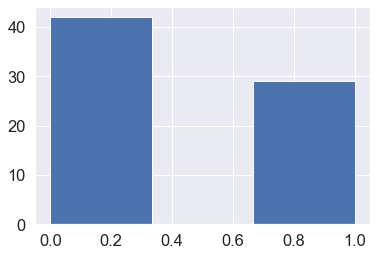

In [227]:
plt.hist(predictions, bins=3)
plt.show()

### Clearly, a vast majority of ExpressionsOOZ followers are not positive about the appointment. Further analysis can be done on why these fans were not happy, and how they can be retain. Perhaps, I will explore this in a future project!